## Funções para plotar gráficos by Matheus


In [1]:

import numpy as np
import matplotlib.pyplot as plt


def plot_sample_images(dataset, class_names, num_images=9):
    """Visualiza amostras do dataset"""
    plt.figure(figsize=(12, 12))

    for images, labels in dataset.take(1):
        for i in range(min(num_images, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            # Pegar nome da classe
            label_idx = np.argmax(labels[i])
            plt.title(class_names[label_idx])
            plt.axis("off")

    plt.tight_layout()
    plt.show()


def plot_training_history(history):
    """Plota o histórico de treinamento do modelo"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia de Treino')
    plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia de Treino e Validação')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda de Treino')
    plt.plot(epochs_range, val_loss, label='Perda de Validação')
    plt.legend(loc='upper right')
    plt.title('Perda de Treino e Validação')

    plt.show()

In [2]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

print("Versão do Tensorflow:")
print(tf.__version__)

Versão do Tensorflow:
2.19.0


# Classificação de Elementos Eletrônicos com TensorFlow e Keras - Tarefa 24

## Carregar dados

Found 10990 files belonging to 36 classes.
Número de classes: 36


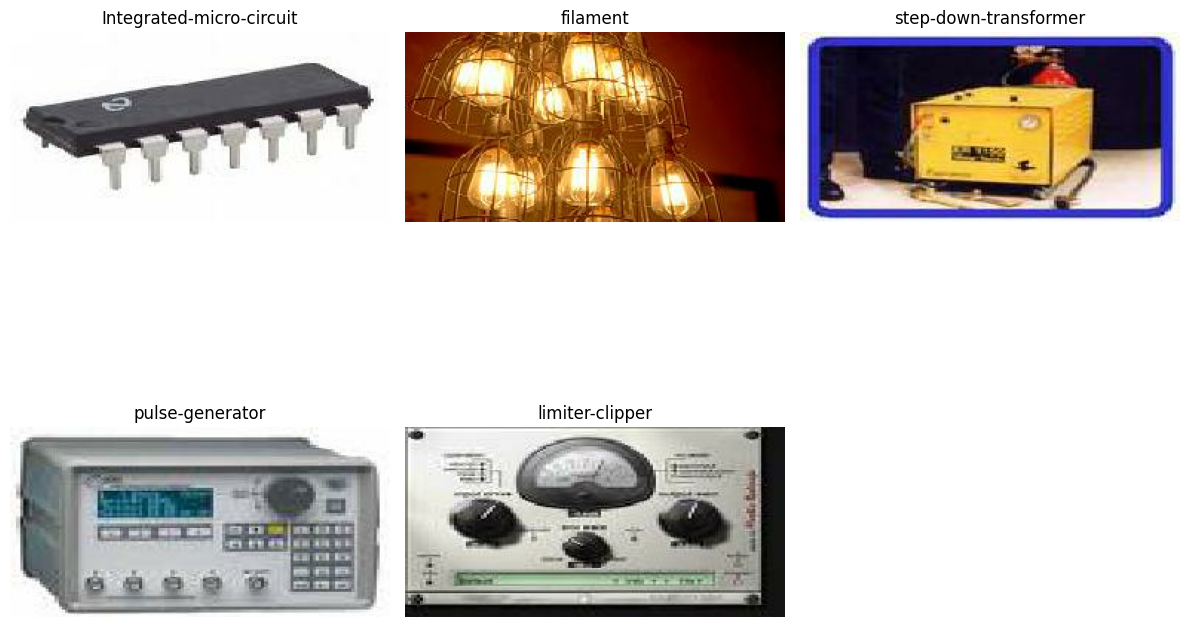

In [5]:
# Configurações
IMG_SIZE = (128, 256)
BATCH_SIZE = 32
SEED = 42

IMAGE_BASE_PATH = path

# Carregar TODOS os dados
full_dataset = tf.keras.utils.image_dataset_from_directory(
    IMAGE_BASE_PATH,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=classes_corretas,
    shuffle=True
)

# Obter informações
class_names = full_dataset.class_names
num_classes = len(class_names)

print(f"Número de classes: {num_classes}")

# Visualizar amostras do dataset
plot_sample_images(full_dataset, class_names, num_images=5)

## Dividir dados em treino, validação e teste

In [10]:
def normalize(image, label):
    return normalization_layer(image), label

total_batches = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.7 * total_batches)
val_size = int(0.15 * total_batches)
test_size = total_batches - train_size - val_size

# Dividir
train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

print(f"Treino: {train_size} batches")
print(f"Validação: {val_size} batches")
print(f"Teste: {test_size} batches")

# Otimização com AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

# 1. Normalização
# Mapeia a normalização usando processamento paralelo
train_dataset = train_dataset.map(normalize, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(normalize, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(normalize, num_parallel_calls=AUTOTUNE)

# 2. Configuração Otimizada e Segura para RAM
# Cache: Se der erro de memória de novo, REMOVA esta linha .cache()
# train_dataset = train_dataset.cache()

# Shuffle: Buffer reduzido para não estourar a RAM (30 batches ~= 960 imagens)
train_dataset = train_dataset.shuffle(buffer_size=30)

# Repeat: Essencial para evitar o erro "OUT_OF_RANGE"
train_dataset = train_dataset.repeat()

# Prefetch: Garante velocidade
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Configuração de Validação e Teste
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print("Pipeline configurada: Shuffle reduzido (RAM segura) e Repeat ativado.")

Treino: 240 batches
Validação: 51 batches
Teste: 53 batches
Pipeline configurada: Shuffle reduzido (RAM segura) e Repeat ativado.


## Criar o modelo

In [11]:
def build_model(input_shape=(128, 256, 3), num_classes=36):
    """
    Modelo CNN para classificação de componentes eletrônicos
    """
    inputs = keras.Input(shape=input_shape)

    # Normalização dentro do modelo
    x = layers.Rescaling(1./255)(inputs)

    # BLOCO 1
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # BLOCO 2
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # BLOCO 3
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # BLOCO 4
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # CLASSIFICADOR
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_electronic_components")
    return model

# Criar modelo com número correto de classes
model = build_model(input_shape=(128, 256, 3), num_classes=num_classes)
model.summary()

Model: "cnn_electronic_components"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,308,644 (66.03 MB)

 Trainable params: 17,307,684 (66.02 MB)

 Non-trainable params: 960 (3.75 KB)

## Treinar o modelo

In [18]:
# ----------------------------
# TREINAR A CNN
# ----------------------------

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
)

EPOCHS = 30

# Criar pasta para modelos se não existir
os.makedirs('../models', exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),

    # Salvar melhor modelo automaticamente
    keras.callbacks.ModelCheckpoint(
        filepath='../models/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=train_size,
    validation_steps=val_size
)

Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0399 - loss: 3.4726 - top5_acc: 0.2256
Epoch 1: val_accuracy improved from -inf to 0.04534, saving model to ../models/best_model_epoch_01_val_acc_0.05.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.0399 - loss: 3.4726 - top5_acc: 0.2256 - val_accuracy: 0.0453 - val_loss: 3.4959 - val_top5_acc: 0.1991 - learning_rate: 0.0100
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0413 - loss: 3.4733 - top5_acc: 0.2124
Epoch 2: val_accuracy did not improve from 0.04534
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.0413 - loss: 3.4733 - top5_acc: 0.2124 - val_accuracy: 0.0343 - val_loss: 3.4961 - val_top5_acc: 0.1991 - learning_rate: 0.0100
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0433 - loss: 3.4764 - top5_acc: 0.2172
Epoch 3: val_accuracy did not improve from 0.04534
240/240 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.0433 - loss: 3.4764 - top5_acc: 0.

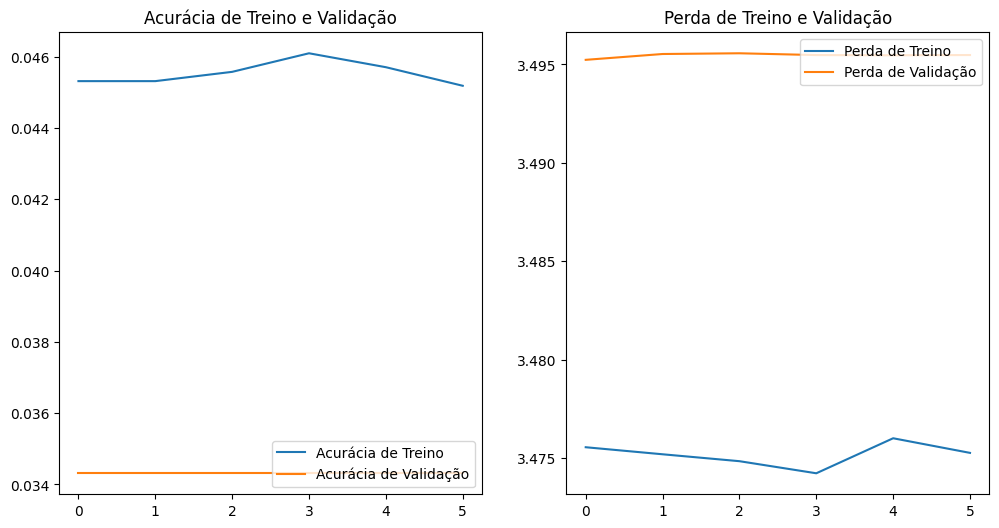

In [14]:
# ----------------------------
# ACURÁCIA DO TREINAMENTO
# ----------------------------

plot_training_history(history)

# Para carregar o modelo:
# model = keras.models.load_model('../models/cnn_electronic_components.keras')